In [ ]:
import numpy as np
import math
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from keras import models, layers, optimizers, metrics, losses, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sn
from keras.layers import ZeroPadding3D
from scipy import io as sio
import os
from matplotlib import pyplot as plt

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat

--2021-12-01 17:52:16--  http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26552770 (25M)
Saving to: ‘Salinas_corrected.mat.1’

Salinas_corrected.m 100%[===================>]  25.32M   538KB/s    in 49s     

2021-12-01 17:53:05 (529 KB/s) - ‘Salinas_corrected.mat.1’ saved [26552770/26552770]

--2021-12-01 17:53:05--  http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4277 (4.2K)
Saving to: ‘Salinas_gt.mat.1’

Salinas_gt.mat.1    100%[===================>]   4.18K  --.-KB/s    in 0s      

2021-12-01 17:53:05 (425 MB/s) - ‘Salinas_gt.mat.1’ saved [4277/4277]

FINISHED --2021-12-01 17:53:05--
Total wall clock time: 50s
Downloaded: 2 files, 25M in 49s (

In [ ]:
!ls

Salinas_corrected.mat	 Salinas_gt.mat    sample_data
Salinas_corrected.mat.1  Salinas_gt.mat.1


## Read the Data

In [ ]:
from scipy.io import loadmat

def read_HSI():
  X = loadmat('Salinas_corrected.mat')['salinas_corrected']
  y = loadmat('Salinas_gt.mat')['salinas_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI() 

X shape: (512, 217, 204)
y shape: (512, 217)


### Visualize Bands

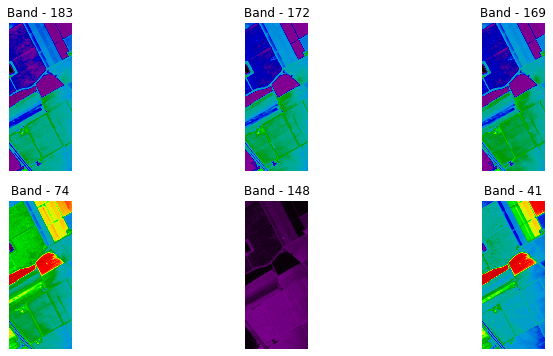

In [ ]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

### Visualize the Ground Truth

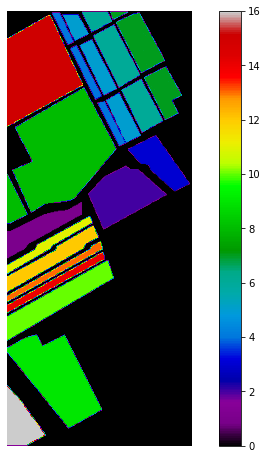

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

## Convert the dataset into csv 

In [ ]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)


In [ ]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band166,band167,band168,band169,band170,band171,band172,band173,band174,band175,band176,band177,band178,band179,band180,band181,band182,band183,band184,band185,band186,band187,band188,band189,band190,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200,band201,band202,band203,band204,class
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,1656,1670,1584,1643,1659,1619,1723,1785,1805,1822,1809,1790,1786,1770,1779,1737,1706,1709,1699,1663,1702,1682,1715,1682,1603,1615,1746,1784,1607,1757,...,424,429,437,409,391,378,364,354,329,340,344,337,321,310,291,284,272,254,240,250,216,220,192,162,173,149,134,129,138,104,96,109,93,54,79,54,36,11,17,0
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,1656,1670,1594,1613,1649,1619,1706,1767,1796,1805,1785,1798,1786,1770,1787,1745,1714,1741,1722,1656,1734,1722,1731,1728,1611,1623,1746,1777,1593,1724,...,429,440,439,409,389,382,370,360,331,342,347,340,323,305,298,282,275,254,240,248,211,225,192,162,180,147,136,131,138,111,94,111,96,56,83,56,36,11,15,0
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,1632,1636,1573,1613,1619,1591,1670,1704,1734,1763,1744,1748,1726,1721,1732,1698,1674,1701,1675,1610,1694,1682,1666,1651,1566,1565,1704,1735,1540,1691,...,417,422,420,395,377,368,358,351,324,332,335,325,318,302,283,276,265,251,240,236,223,216,188,162,176,142,125,129,129,106,88,107,89,54,81,54,30,11,11,0
3,290,381,585,999,1316,1374,1280,1380,1584,1631,1596,1603,1531,1562,1580,1526,1617,1668,1707,1704,1703,1698,1675,1680,1677,1651,1609,1620,1605,1571,1615,1609,1601,1604,1513,1499,1647,1660,1486,1620,...,401,408,411,387,365,361,346,339,310,316,325,318,304,285,276,267,260,239,223,234,201,209,176,161,164,136,127,123,131,100,86,105,85,56,75,50,30,11,19,0
4,219,381,585,999,1286,1352,1261,1396,1555,1618,1596,1558,1489,1532,1531,1508,1599,1632,1672,1687,1662,1664,1658,1639,1645,1612,1585,1596,1589,1525,1583,1569,1568,1566,1468,1478,1605,1612,1446,1574,...,394,410,397,376,356,351,340,332,303,318,321,315,297,287,271,265,246,230,216,226,194,202,178,150,167,127,125,120,122,96,83,105,83,48,75,50,24,9,17,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111104 entries, 0 to 111103
Columns: 205 entries, band1 to class
dtypes: int16(204), uint8(1)
memory usage: 43.3 MB


In [ ]:
df.iloc[:, :-1].describe()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band165,band166,band167,band168,band169,band170,band171,band172,band173,band174,band175,band176,band177,band178,band179,band180,band181,band182,band183,band184,band185,band186,band187,band188,band189,band190,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200,band201,band202,band203,band204
count,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,...,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000,111104.000000
mean,372.181929,480.388321,693.751287,1156.562923,1462.129950,1533.406025,1473.193944,1634.795552,1866.721801,1930.824417,1921.302095,1939.886233,1859.040143,1908.443845,1937.982314,1912.241089,2052.537109,2146.760900,2203.999163,2220.420732,2196.853417,2184.372534,2169.784517,2160.080618,2188.279432,2145.107971,2107.840114,2133.192315,2111.963233,2053.756156,2130.088998,2122.770458,2111.508227,2111.173711,1996.933171,2024.596981,2294.604443,2463.213845,2374.180660,2809.752691,...,490.748596,484.301744,494.405404,492.323517,465.276129,441.804039,432.134748,424.404396,416.762196,389.574579,404.550664,409.568755,401.047577,384.198526,365.354515,342.899806,330.627124,318.849852,297.291673,280.387403,289.618979,248.977112,263.452756,228.025310,199.018424,216.422415,176.978084,163.636872,161.571681,169.267083,132.158959,116.093219,138.739181,117.048180,71.937059,104.474825,71.262025,39.304778,14.063463,22.294175
std,62.453906,80.614130,103.217542,170.676450,227.876068,260.417860,271.714302,329.998481,404.351771,445.485781,468.920942,499.029949,501.816761,536.268501,554.684845,536.984170,550.262525,560.809801,575.930308,591.973018,618.675137,660.068345,690.011048,709.212106,738.993323,750.136506,754.262250,776.287152,794.172472,794.955507,849.344759,855.579662,838.190922,852.359589,793.210696,711.871421,630.031577,532.611512,532.231323,857.319436,...,238.235637,232.676838,235.042607,231.723645,216.459394,202.950425,196.281598,190.640075,184.731505,170.745921,176.509463,179.935962,177.464491,171.441905,165.267346,157.922341,154.801712,150.994137,142.355080,136.063726,142.330227,123.214460,131.351321,115.003115,101.644715,111.333987,91.831239,85.591075,85.201187,90.038614,71.227778,63.216203,76.108928,65.012702,40.255958,59.222728,41.232828,23.280864,9.088472,13.735217
min,87.000000,86.000000,90.000000,86.000000,91.000000,91.000000,88.000000,88.000000,87.000000,86.000000,84.000000,83.000000,79.000000,78.000000,78.000000,70.000000,67.000000,64.000000,66.000000,59.000000,53.000000,46.000000,35.000000,20.000000,10.000000,5.000000,1.000000,0.000000,-2.000000,2.000000,1.000000,1.000000,2.000000,4.000000,0.000000,2.000000,1.000000,4.000000,10.000000,14.000000,...,12.000000,9.000000,10.000000,12.000000,10.000000,10.000000,10.000000,6.000000,9.000000

## Principal Component Analysis(PCA)


---



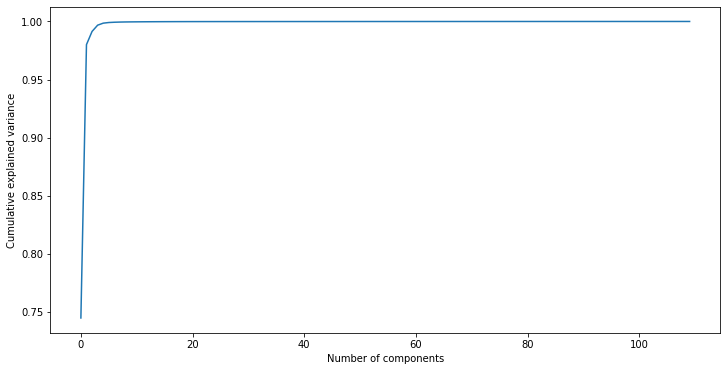

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 110)# 95 115

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()


Select 40 as the no.of components for PCA

In [ ]:
pca = PCA(n_components = 15) #10 5 15 
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,16)]+['class']

In [ ]:
q.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12,PC-13,PC-14,PC-15,class
0,-6136.415770,-4385.651601,628.426690,-302.089387,-7.164320,48.222012,-129.801973,-28.045863,31.953506,69.756525,-9.096389,2.149289,-17.391735,-2.090865,-5.088566,0
1,-6196.986718,-4360.590266,568.289463,-269.925094,-1.914969,-13.422142,-141.516132,-48.425747,56.946711,62.859663,12.702875,21.524974,-22.385933,-50.675562,7.880171,0
2,-6359.538817,-4693.892811,578.047775,-286.413937,18.366365,-17.493501,-122.449201,-23.107800,27.357095,64.968585,-4.313188,27.925710,-16.629587,0.212182,0.818616,0
3,-6583.700658,-5103.974489,630.466845,-313.787607,39.673922,-9.386642,-130.574810,-14.943107,24.519472,63.060403,-9.042420,27.000649,-19.678950,-1.861730,-11.117053,0
4,-6834.644650,-5385.604040,666.876042,-327.332038,24.787586,-19.604360,-134.531359,-30.850479,28.726584,83.725078,-10.376535,20.125160,-81.282150,20.465575,-7.588561,0


### Display the bands after PCA

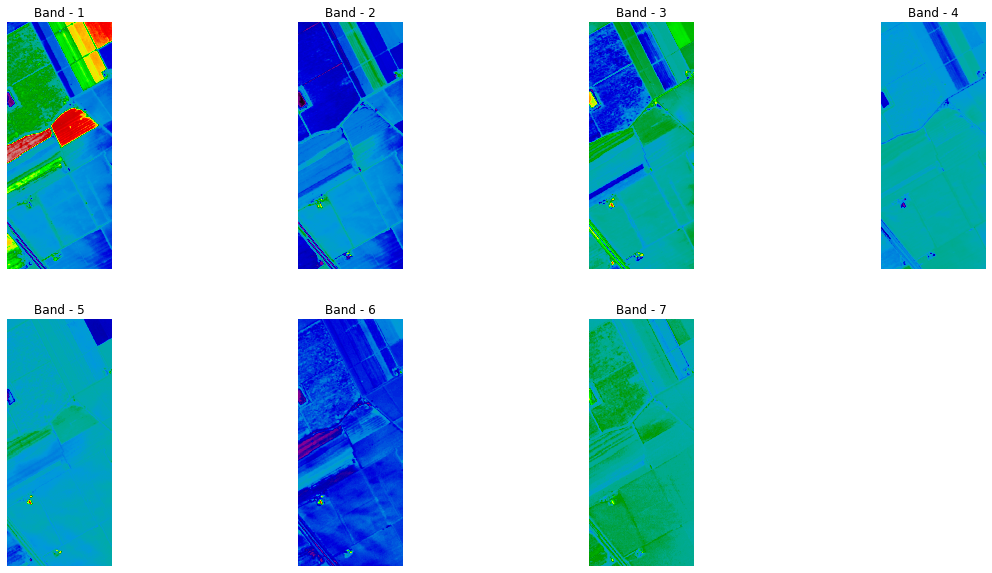

In [ ]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 1+7):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(512,217), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

plt.savefig('SA_PCA_Bands.png')

In [ ]:
# saving to .csv
q.to_csv('SA_40_PCA.csv', index=False)

### Display the bands after PCA

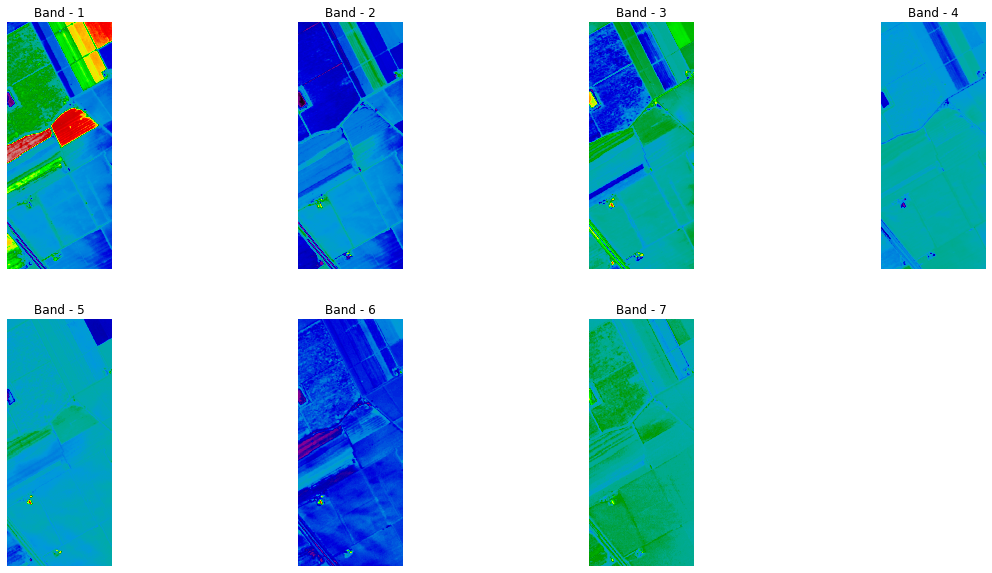

In [ ]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 1+7):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(512,217), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

plt.savefig('SA_PCA_Bands.png')

In [ ]:
# saving to .csv
q.to_csv('SA_40_PCA.csv', index=False)

## Incremental Principal Component Analysis(PCA)


---



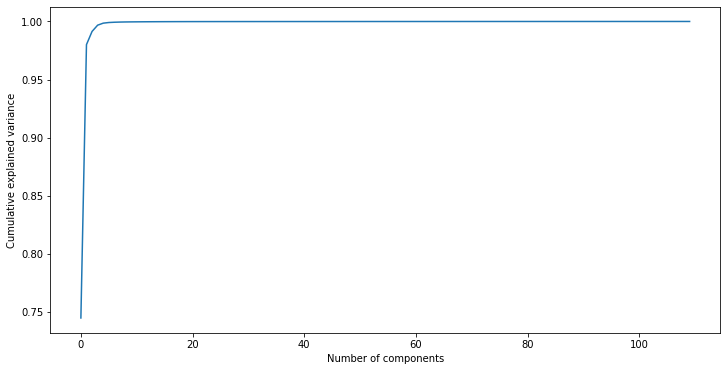

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 110)# 95 115

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()


Select 40 as the no.of components for PCA

In [ ]:
pca = PCA(n_components = 15) #10 5 15 
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,16)]+['class']

In [ ]:
q.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12,PC-13,PC-14,PC-15,class
0,-6136.415770,-4385.651601,628.426690,-302.089387,-7.164320,48.222012,-129.801973,-28.045863,31.953506,69.756525,-9.096389,2.149289,-17.391735,-2.090865,-5.088566,0
1,-6196.986718,-4360.590266,568.289463,-269.925094,-1.914969,-13.422142,-141.516132,-48.425747,56.946711,62.859663,12.702875,21.524974,-22.385933,-50.675562,7.880171,0
2,-6359.538817,-4693.892811,578.047775,-286.413937,18.366365,-17.493501,-122.449201,-23.107800,27.357095,64.968585,-4.313188,27.925710,-16.629587,0.212182,0.818616,0
3,-6583.700658,-5103.974489,630.466845,-313.787607,39.673922,-9.386642,-130.574810,-14.943107,24.519472,63.060403,-9.042420,27.000649,-19.678950,-1.861730,-11.117053,0
4,-6834.644650,-5385.604040,666.876042,-327.332038,24.787586,-19.604360,-134.531359,-30.850479,28.726584,83.725078,-10.376535,20.125160,-81.282150,20.465575,-7.588561,0


### Display the bands after PCA

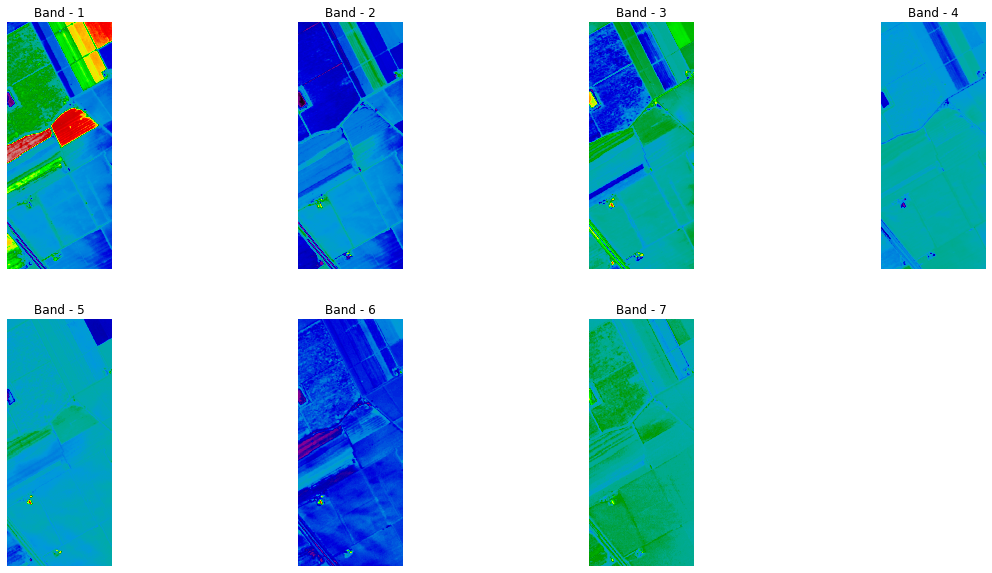

In [ ]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 1+7):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(512,217), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

plt.savefig('SA_PCA_Bands.png')

In [ ]:
# saving to .csv
q.to_csv('SA_40_PCA.csv', index=False)

### Display the bands after PCA

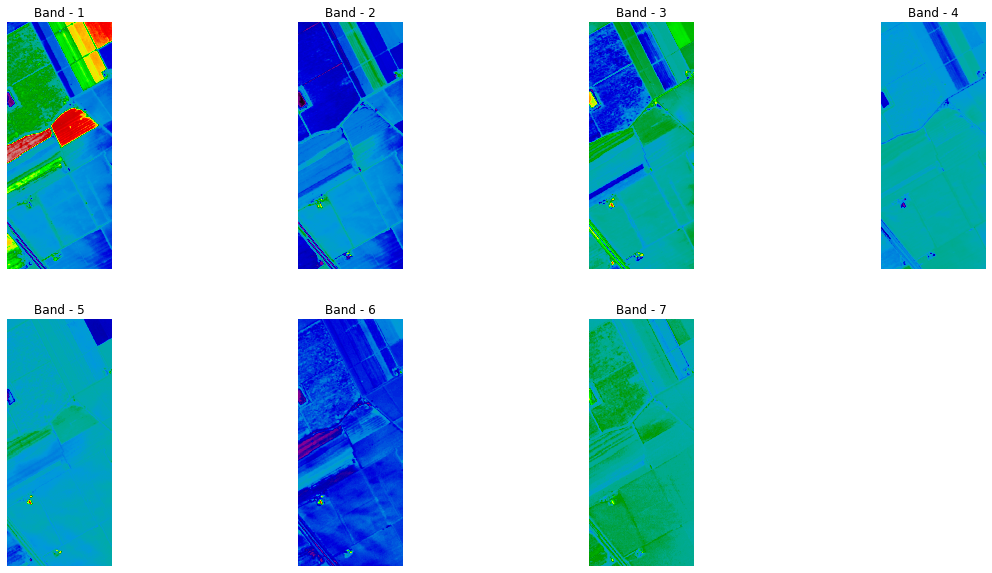

In [ ]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 1+7):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(512,217), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

plt.savefig('SA_PCA_Bands.png')

In [ ]:
# saving to .csv
q.to_csv('SA_40_PCA.csv', index=False)

## Support Vector Machine(SVM)


In [ ]:
x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 

names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth','Stubble','Celery','Grapes_untrained',
'Soil_vinyard_develop','Corn_senesced_green_weeds','Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','	Lettuce_romaine_7wk',
'Vinyard_untrained','Vinyard_vertical_trellis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11, stratify=y) #test 5,10,15,20,25,30
svm =  SVC(C = 100, kernel = 'rbf', cache_size = 10*1024) #kernel change

svm.fit(X_train, y_train)
ypred = svm.predict(X_test)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9 missing from current font.



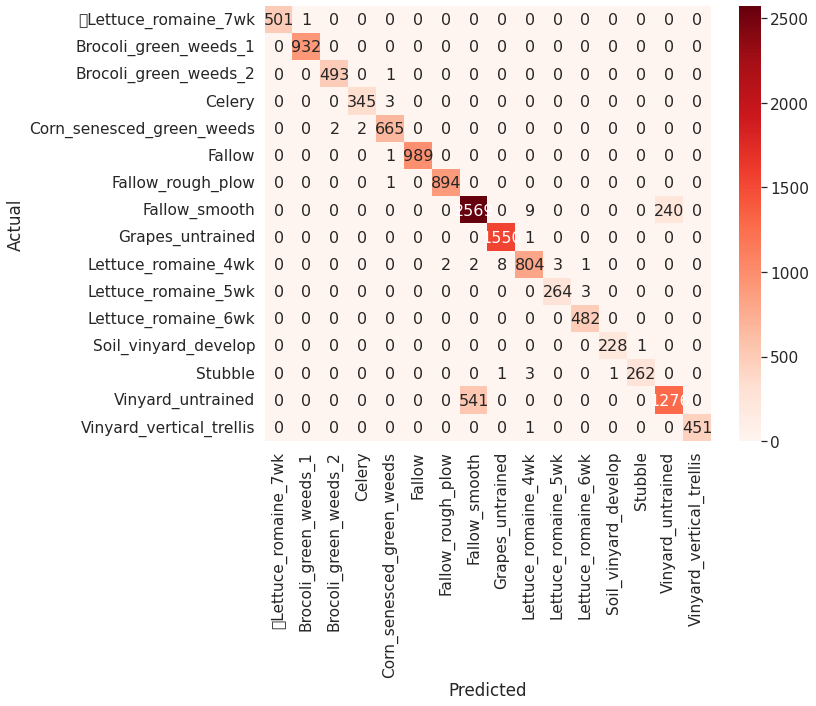

In [ ]:
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [ ]:
print(classification_report(y_test, ypred, target_names = names))

                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       1.00      1.00      1.00       502
    Brocoli_green_weeds_2       1.00      1.00      1.00       932
                   Fallow       1.00      1.00      1.00       494
        Fallow_rough_plow       0.99      0.99      0.99       348
            Fallow_smooth       0.99      0.99      0.99       669
                  Stubble       1.00      1.00      1.00       990
                   Celery       1.00      1.00      1.00       895
         Grapes_untrained       0.83      0.91      0.87      2818
     Soil_vinyard_develop       0.99      1.00      1.00      1551
Corn_senesced_green_weeds       0.98      0.98      0.98       820
      Lettuce_romaine_4wk       0.99      0.99      0.99       267
      Lettuce_romaine_5wk       0.99      1.00      1.00       482
      Lettuce_romaine_6wk       1.00      1.00      1.00       229
     	Lettuce_romaine_7wk       1.00      0.98      0.99     

## Classification Map

In [ ]:
l=[]
for i in range(q.shape[0]):
  if q.iloc[i, -1] == 0:
    l.append(0)
  else:
    l.append(svm.predict(q.iloc[i, :-1].values.reshape(1, -1)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



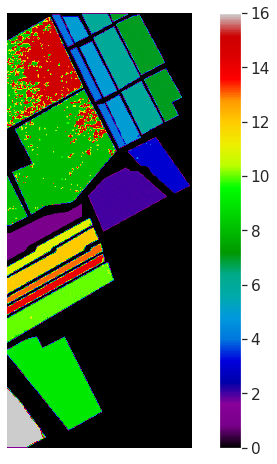

In [ ]:
clmap = np.array(l).reshape(512,217).astype('float')
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('SA_cmap.png')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [ ]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9589891376634893


In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 6.943249833739747
Mean Squared Error: 1.8907115938816228
Root Mean Squared Error: 1.3750314883236758


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 501    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0  931    0    0    0    0    0    0    0    0    0    0    0    0
     0    1]
 [   0    0  492    0    1    0    0    0    0    1    0    0    0    0
     0    0]
 [   0    0    0  345    3    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    2    1  665    0    0    1    0    0    0    0    0    0
     0    0]
 [   0    0    1    0    0  989    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    1    0  894    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0 2648    1    4    0    0    0    0
   165    0]
 [   0    0    0    0    0    0    0    0 1551    0    0    0    0    0
     0    0]
 [   0    0    2    0    0    0    0    1    9  806    0    0    0    0
     0    2]
 [   0    0    0    0    0    0    0    0    1    0  265    1    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0  482    